In [6]:
import numpy as np
import queue
from statistics import mean
import matplotlib.pyplot as plt
import math
import random

In [19]:
def avl_server(t,servers):
    low = len(servers)
    i = 0
    for s in servers:
        if t > s[1]:
            if low == len(servers):
                low = i
            elif s[1] < servers[low][1]:
                low = i
        i += 1
    if low < len(servers):
        return low #return server with earliest idle time
    return len(servers)

def get_avl_servers(t,servers,n):
    empty = []
    i = 0
    for s in servers:
        if t >= s[1]: #get empty servers
            empty.append((i,s[1]))
        i += 1
    empty.sort(key = lambda x: x[1])
    return empty[:n] #return the [server index,free time]

def busy_server_n(t,servers):
    n = 0
    i = 0
    for s in servers:
        if t >= s[1] or t < s[0]: #get empty servers
            n += 1
            #print(i)
        i+=1
    return len(servers)-n #reverse

def get_job_size():
    size = random.randint(1,10)
    if size < 10:
        return 1
    return size

def get_srv_rate(job_size):
    if job_size == 1:
        return 5
    elif job_size == 10:
        return 1

In [ ]:
arr_rate = 1
duration = 3600*10
#job_size = 10

server_n = 10
#srv_rate = 5

t = 0
jobs_arr_t = []
while t <= duration:
    iat = np.random.exponential(1/arr_rate)
    t += iat
    #jobs_arr_t.append((t,random.choice([1,job_size])))
    jobs_arr_t.append((t,get_job_size()))

jobs_arr_t

In [177]:
utils = []
throughputs = []
max_lambda = 30
#arr_rate_list = range(1,max_lambda+1)
arr_rate_list = np.arange(0.1,max_lambda,0.1)

for arr_rate in arr_rate_list:
    tmp_thru = []
    duration = 3600*1
    #job_size = 10

    server_n = 10
    #srv_rate = 5

    # POPULATE THE JOBS ARRIVAL TIMES AND JOB SIZE
    t = 0
    jobs_arr_t = []
    while t <= duration:
        iat = np.random.exponential(1/arr_rate)
        t += iat
        #jobs_arr_t.append((t,random.choice([1,job_size])))
        jobs_arr_t.append((t,get_job_size()))

    comb_wt = []
    comb_rt = []
    comb_sl = []
    comb_qs = []

    waiting_times = []
    response_times = []
    queue = []

    # INITIATE THE N SERVERS
    servers = [] #[service_start,end]
    for s in range(server_n):
        servers.append([0,0])

    server_load = [[0,0]]
    queue_size = [[0,0]]
    throughput_1 = 0
    throughput_10 = 0

    job_id = 0
    # ITERATE EVENT-BASED (CAN BE JOBS ARRIVAL OR SERVICE FINISHED)
    while job_id < len(jobs_arr_t):
        t = 999999999
        curr_job = jobs_arr_t[job_id] 
        # ITERATE ALL THE SERVERS AND GET THE NEXT EARLIEST SERVER FINISH
        for s in servers:
            if s[1] > 0 and s[1] < t and s[1] > server_load[-1][0]:
                t = s[1]
        # GET THE NEXT JOBS ARRIVAL
        if jobs_arr_t[job_id][0] < t:
            t = jobs_arr_t[job_id][0]
            queue.append(curr_job)
            job_id += 1
        # NOW, t IS THE NEXT EVENT HAPPENING
        #print(t)

        # HOL TECHNIQUE WHERE SCHEDULERS PRIORITIZE THE JOBS AT THE FRONT,
        # AND WAIT UNTIL HOWEVER MANY SERVERS THAT JOB NEEDS ARE AVAILABLE
        if len(queue) > 0:
            job = queue[0] #only the job at the front
            avl_servers_n = len(servers)-busy_server_n(t,servers) #get the number of available servers
            if avl_servers_n >= job[1]: #if it's enough for the job at the front
                ready_servers = get_avl_servers(t,servers,job[1]) #get all the servers ready to service
                st = np.random.exponential(1/get_srv_rate(job[1])) #determine the service rate
                for s in ready_servers:# put the job in each ready server
                    server_id = s[0]
                    servers[server_id] = [t,t+st]
                waiting_times.append((t-job[0],job[1])) #for graph purpose
                response_times.append((t+st-job[0],job[1])) #for graph purpose
                queue.pop(0)
                if job[1] == 10: #for graph purpose
                    throughput_10 += 1
                else:
                    throughput_1 += 1

        server_load.append((t,busy_server_n(t,servers))) #for graph purpose
        queue_size.append((t,len(queue))) #for graph purpose

    #for graph purpose
    comb_wt.append(waiting_times)
    comb_rt.append(response_times)
    comb_sl.append(server_load)
    comb_qs.append(queue_size)
    
    tmp_thru.append((throughput_1,throughput_10))


    # NON FIFO (CAN OVERTAKE)
    waiting_times = []
    response_times = []
    queue = []

    servers = [] #[service_start,end]
    for s in range(server_n):
        servers.append([0,0])

    server_load = [[0,0]]
    queue_size = [[0,0]]
    throughput_1 = 0
    throughput_10 = 0

    job_id = 0
    while job_id < len(jobs_arr_t):
        t = 999999999
        curr_job = jobs_arr_t[job_id]        
        for s in servers:
            if s[1] > 0 and s[1] < t and s[1] > server_load[-1][0]:
                t = s[1]
        if jobs_arr_t[job_id][0] < t:
            t = jobs_arr_t[job_id][0]
            queue.append(curr_job)
            job_id += 1
        #print(t)

        # HOL TECHNIQUE WHERE THE SMALLER JOBS CAN OVERTAKE THE BIGGER JOBS,
        # IF THE AVAILABLE SERVERS ARE NOT ENOUGH FOR THE BIG JOB, BUT ENOUGH FOR THAT SMALLER JOB
        queue_id = 0
        while queue_id < len(queue):
            avl_servers_n = len(servers)-busy_server_n(t,servers)
            # NO NEED TO ITERATE THE QUEUE ANYMORE SINCE ALL SERVERS ARE BUSY
            if avl_servers_n == 0:
                break
            job = queue[queue_id]
            if avl_servers_n >= job[1]:
                ready_servers = get_avl_servers(t,servers,job[1])
                st = np.random.exponential(1/get_srv_rate(job[1]))
                for s in ready_servers:
                    server_id = s[0]
                    servers[server_id] = [t,t+st]
                waiting_times.append((t-job[0],job[1]))
                response_times.append((t+st-job[0],job[1]))
                queue.pop(queue_id)
                queue_id = 0
                if job[1] == 10:
                    throughput_10 += 1
                else:
                    throughput_1 += 1
            else: #IF THAT JOB IS TOO BIG FOR THE AVAILABLE SERVERS, WE CAN CHECK THE NEXT JOB IN QUEUE
                queue_id += 1
        server_load.append((t,busy_server_n(t,servers))) #for graph purpose
        queue_size.append((t,len(queue))) #for graph purpose

    #for graph purpose
    comb_wt.append(waiting_times)
    comb_rt.append(response_times)
    comb_sl.append(server_load)
    comb_qs.append(queue_size)
    
    tmp_thru.append((throughput_1,throughput_10))
    
    print('Arrival rate: '+str(arr_rate))
    
    # counting the utilization
    tmp_util = []
    for a in range(2):
        server_load = comb_sl[a]
        queue_size = comb_qs[a]

        util = 0 
        i = 1

        while i < len(server_load):
            time = server_load[i][0] - server_load[i-1][0]
            load = server_load[i-1][1]
            util += (time*load)
            i += 1

        avg_util = util/duration/server_n
        tmp_util.append(avg_util)
        print(avg_util)
    print(tmp_thru)
    print('------------')
    utils.append(tmp_util)
    throughputs.append(tmp_thru)

Arrival rate: 0.1
0.010080333553054046
0.012388864304456671
[(330, 32), (330, 32)]
------------
Arrival rate: 0.2
0.021690774442858534
0.023395425693202274
[(678, 70), (678, 70)]
------------
Arrival rate: 0.30000000000000004
0.03619845454689745
0.04123455619224649
[(940, 129), (940, 129)]
------------
Arrival rate: 0.4
0.059519920088726516
0.04643221010389041
[(1320, 172), (1320, 172)]
------------
Arrival rate: 0.5
0.0544127784456904
0.05023413379873799
[(1690, 156), (1690, 156)]
------------
Arrival rate: 0.6
0.07398381506915805
0.06132401297149426
[(1966, 212), (1966, 212)]
------------
Arrival rate: 0.7000000000000001
0.08298497209958414
0.08665064970253715
[(2202, 270), (2202, 270)]
------------
Arrival rate: 0.8
0.09732349644516074
0.10046115708991518
[(2701, 288), (2698, 288)]
------------
Arrival rate: 0.9
0.11373785922253406
0.10996208907262675
[(2895, 349), (2895, 349)]
------------
Arrival rate: 1.0
0.11320824503537738
0.12492083449198803
[(3289, 343), (3289, 343)]
--------

Arrival rate: 8.1
0.704087700721463
0.9522106197718868
[(18964, 2061), (26424, 2815)]
------------
Arrival rate: 8.2
0.6846963845316943
0.9488155904617619
[(19419, 2176), (25918, 2921)]
------------
Arrival rate: 8.3
0.7003432726754251
0.9702979665280249
[(19341, 2155), (26425, 2861)]
------------
Arrival rate: 8.4
0.7053022996366122
0.9758864502422238
[(18845, 2117), (26894, 2982)]
------------
Arrival rate: 8.5
0.6991135101947642
0.971443139302977
[(19592, 2094), (27528, 2919)]
------------
Arrival rate: 8.6
0.6991933005840543
0.978768280978237
[(19006, 2145), (27359, 2930)]
------------
Arrival rate: 8.7
0.7024747163694139
0.9782657178026634
[(19259, 2081), (27716, 2935)]
------------
Arrival rate: 8.8
0.7043793590838592
0.9860975149193386
[(18907, 2102), (28388, 2966)]
------------
Arrival rate: 8.9
0.6995561582952087
0.9909394810905103
[(19456, 2150), (27856, 3028)]
------------
Arrival rate: 9.0
0.7063301763103722
0.9932643257242779
[(18397, 2212), (26194, 2990)]
------------
Arr

Arrival rate: 16.1
0.7276162920044078
0.9959890555052431
[(20581, 2269), (47972, 2623)]
------------
Arrival rate: 16.200000000000003
0.737562824650587
0.9958238743358583
[(19405, 2178), (51983, 2555)]
------------
Arrival rate: 16.3
0.7292941283512289
0.997916899798649
[(20003, 2270), (39564, 2607)]
------------
Arrival rate: 16.400000000000002
0.733905904357609
0.9974239959951088
[(20368, 2250), (33879, 2871)]
------------
Arrival rate: 16.500000000000004
0.7322547176024742
0.9978870271872102
[(20322, 2236), (48058, 2638)]
------------
Arrival rate: 16.6
0.7395076072079328
0.9970591028671952
[(20283, 2209), (39058, 2882)]
------------
Arrival rate: 16.700000000000003
0.7323368125183463
0.9958338963839065
[(19809, 2292), (27620, 3034)]
------------
Arrival rate: 16.8
0.7343086082064731
0.99697289666824
[(19835, 2248), (36182, 2886)]
------------
Arrival rate: 16.900000000000002
0.7356273598485408
0.9961905528024063
[(19609, 2272), (52235, 2520)]
------------
Arrival rate: 17.000000000

Arrival rate: 23.6
0.7523847303888319
0.9987949890124647
[(20701, 2288), (51397, 2605)]
------------
Arrival rate: 23.700000000000003
0.7388940219942775
0.9940477962706126
[(21288, 2358), (72304, 2102)]
------------
Arrival rate: 23.800000000000004
0.750525010094773
0.99769314857219
[(19689, 2247), (34773, 2973)]
------------
Arrival rate: 23.900000000000002
0.7479545283567088
0.9961515176036138
[(20415, 2281), (71586, 2198)]
------------
Arrival rate: 24.000000000000004
0.7515202791425756
0.9950043636070547
[(19791, 2212), (54135, 2444)]
------------
Arrival rate: 24.1
0.750695077525095
0.9966839479356613
[(20448, 2281), (55537, 2448)]
------------
Arrival rate: 24.200000000000003
0.7569621258597242
0.9959187909746797
[(20596, 2245), (28009, 2987)]
------------
Arrival rate: 24.300000000000004
0.7494956069585599
0.9949727362479255
[(20537, 2305), (27344, 3031)]
------------
Arrival rate: 24.400000000000002
0.7457442772187519
0.9950910206976902
[(21385, 2320), (76761, 2001)]
----------

In [178]:
throughputs

[[(330, 32), (330, 32)],
 [(678, 70), (678, 70)],
 [(940, 129), (940, 129)],
 [(1320, 172), (1320, 172)],
 [(1690, 156), (1690, 156)],
 [(1966, 212), (1966, 212)],
 [(2202, 270), (2202, 270)],
 [(2701, 288), (2698, 288)],
 [(2895, 349), (2895, 349)],
 [(3289, 343), (3289, 343)],
 [(3585, 429), (3585, 429)],
 [(3910, 423), (3910, 423)],
 [(4354, 444), (4354, 444)],
 [(4543, 467), (4543, 467)],
 [(4782, 523), (4782, 523)],
 [(5311, 537), (5311, 537)],
 [(5548, 620), (5550, 620)],
 [(5877, 675), (5877, 675)],
 [(6115, 692), (6115, 692)],
 [(6583, 716), (6583, 716)],
 [(6819, 751), (6819, 751)],
 [(7232, 781), (7232, 781)],
 [(7345, 877), (7345, 877)],
 [(7818, 842), (7818, 842)],
 [(8224, 928), (8229, 928)],
 [(8383, 948), (8389, 948)],
 [(8721, 942), (8721, 941)],
 [(9011, 1038), (9011, 1038)],
 [(9313, 1025), (9313, 1025)],
 [(9922, 1058), (9922, 1058)],
 [(9992, 1112), (9995, 1113)],
 [(10472, 1179), (10476, 1179)],
 [(10798, 1208), (10798, 1208)],
 [(11083, 1167), (11082, 1166)],
 [(1

In [175]:
utils

[[0.016132084684207952, 0.015013000091960363],
 [0.024049459736770827, 0.02458966535327014],
 [0.03917840928703244, 0.03815060318397869],
 [0.04964190199670805, 0.047851651219860826],
 [0.062748721977116, 0.05641924395125767],
 [0.07556739528673208, 0.07684094002659889],
 [0.07841699740628413, 0.08564864717742506],
 [0.08965903493039194, 0.10149658210074582],
 [0.10088494992608799, 0.10967417890141289],
 [0.11832333813740863, 0.12359368708561724],
 [0.12909193331483, 0.13595585564880533],
 [0.1504685813553412, 0.13498316545619699],
 [0.15864667105001298, 0.1605350594657609],
 [0.17070441955492294, 0.15436663604033166],
 [0.1815527929618183, 0.19122462682093844],
 [0.20148972450302077, 0.1916677326700415],
 [0.22787168187945647, 0.23036615526306886],
 [0.22635478176177787, 0.22284422039827093],
 [0.22837490028818305, 0.2293787162470775],
 [0.22846401650732573, 0.22821875312710022],
 [0.2388187731523581, 0.24379330459308432],
 [0.26725302423529107, 0.26230568326185194],
 [0.2658419274423

In [73]:
throughputs = [[(32400, 3658), (32400, 3658)], [(65115, 7133), (65115, 7132)], [(97012, 10827), (97012, 10827)], [(130967, 14642), (130952, 14640)], [(161528, 18266), (161530, 18267)], [(185713, 20936), (194090, 21871)], [(188657, 21085), (227694, 25276)], [(190415, 21078), (258446, 28659)], [(191881, 21445), (286691, 30390)], [(195418, 21658), (305235, 29656)]]

In [83]:
utils = [[0.11752516011595882, 0.11480103821041113], [0.2370408443551714, 0.23579808094090676], [0.34997848899582856, 0.3593130581816084], [0.4783330727921272, 0.47154237406224375], [0.5894864285918426, 0.5935207911855576], [0.6769257307888815, 0.7067056465659465], [0.6871275030930382, 0.826451362290548], [0.6943885391356772, 0.9401121348700098], [0.7053784773204848, 0.9983528709052522], [0.7088392304842354, 0.9992131202745158]]

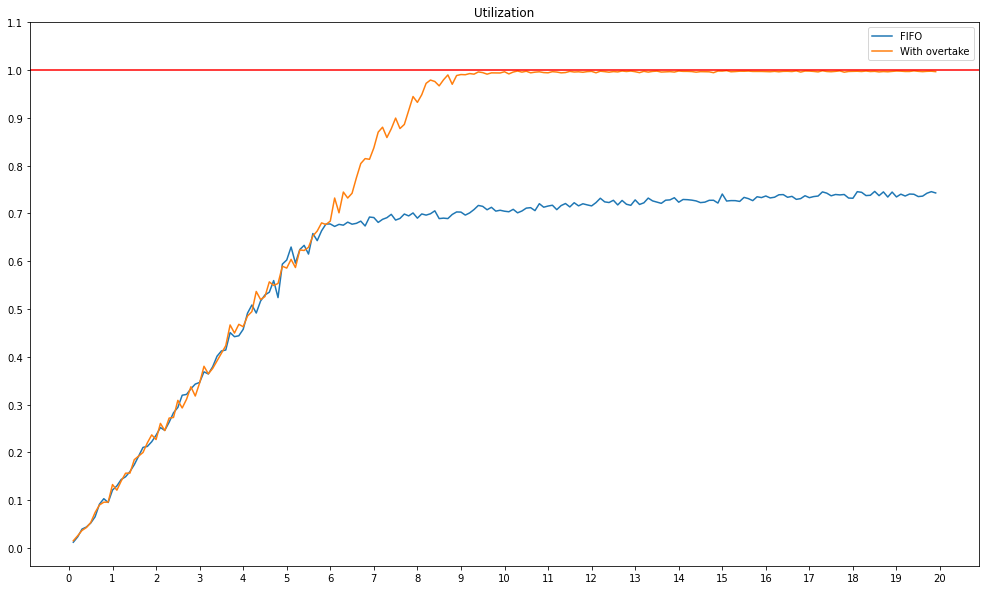

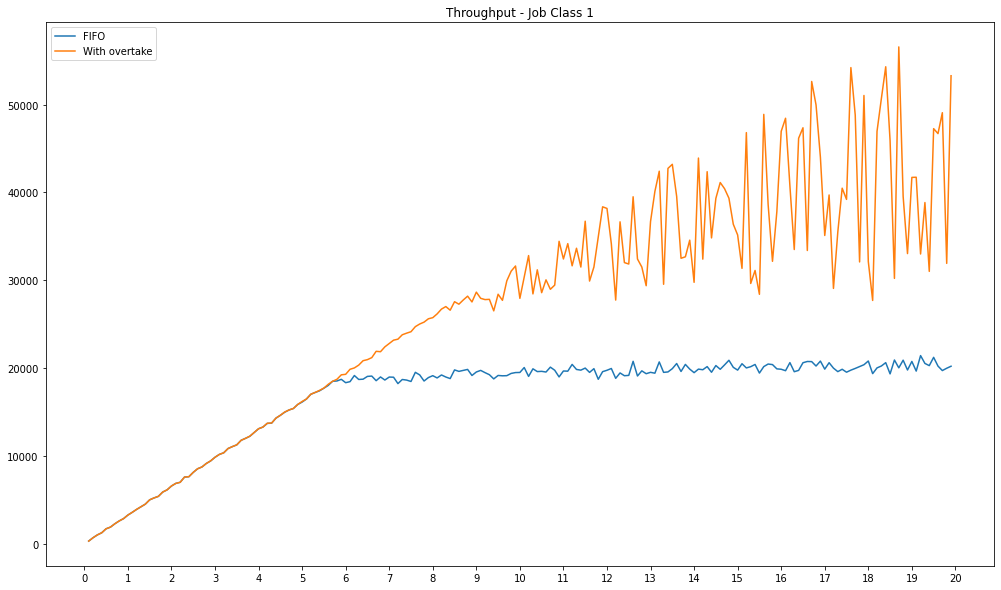

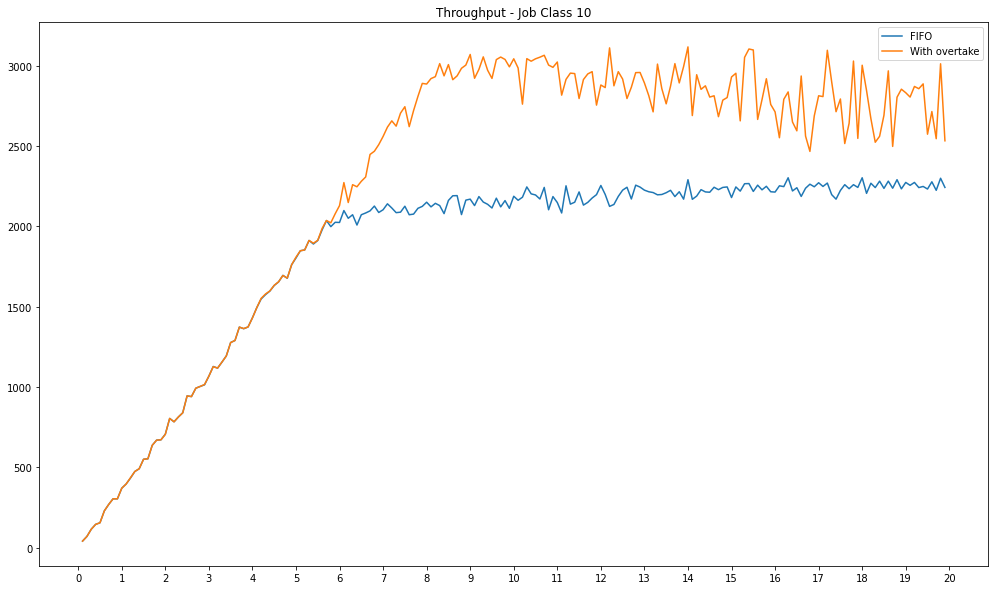

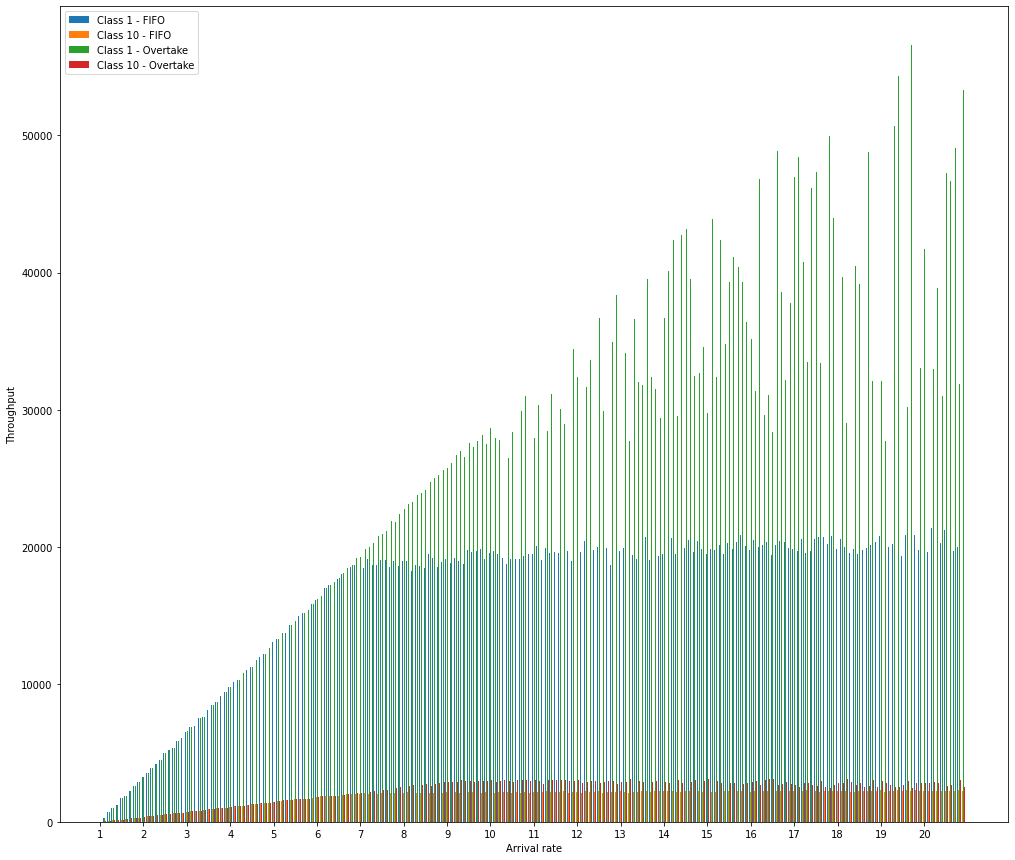

In [169]:
plt.figure(figsize=(17,10))
plt.plot([r for r in np.arange(0.1,max_lambda,0.1)], [u[0] for u in utils], label = 'FIFO')
plt.plot([r for r in np.arange(0.1,max_lambda,0.1)], [u[1] for u in utils], label = 'With overtake')
plt.axhline(y = 1, color = 'r')
plt.yticks(np.arange(0, 1.2, 0.1))
plt.xticks(np.arange(0, max_lambda+1, 1))
plt.legend()
plt.title('Utilization')
plt.show()

plt.figure(figsize=(17,10))
plt.plot([r for r in np.arange(0.1,max_lambda,0.1)], [t[0][0] for t in throughputs], label = 'FIFO')
plt.plot([r for r in np.arange(0.1,max_lambda,0.1)], [t[1][0] for t in throughputs], label = 'With overtake')
plt.xticks(np.arange(0, max_lambda+1, 1))
plt.legend()
plt.title('Throughput - Job Class 1')
plt.show()

plt.figure(figsize=(17,10))
plt.plot([r for r in np.arange(0.1,max_lambda,0.1)], [t[0][1] for t in throughputs], label = 'FIFO')
plt.plot([r for r in np.arange(0.1,max_lambda,0.1)], [t[1][1] for t in throughputs], label = 'With overtake')
plt.xticks(np.arange(0, max_lambda+1, 1))
plt.legend()
plt.title('Throughput - Job Class 10')
plt.show()

plt.figure(figsize=(17,15))
width = 0.02
plt.bar([n for n in np.arange(0.1,max_lambda,0.1)], [t[0][0] for t in throughputs], width = width, label = 'Class 1 - FIFO')
plt.bar([n+width for n in np.arange(0.1,max_lambda,0.1)], [t[0][1] for t in throughputs], width = width, label = 'Class 10 - FIFO')
plt.bar([n+(width*2) for n in np.arange(0.1,max_lambda,0.1)], [t[1][0] for t in throughputs], width = width, label = 'Class 1 - Overtake')
plt.bar([n+(width*3) for n in np.arange(0.1,max_lambda,0.1)], [t[1][1] for t in throughputs], width = width, label = 'Class 10 - Overtake')
plt.legend()
plt.xlabel('Arrival rate')
plt.ylabel('Throughput')
plt.xticks([n+(width*1.5) for n in range(max_lambda)],
        [n+1 for n in range(max_lambda)])
plt.show()

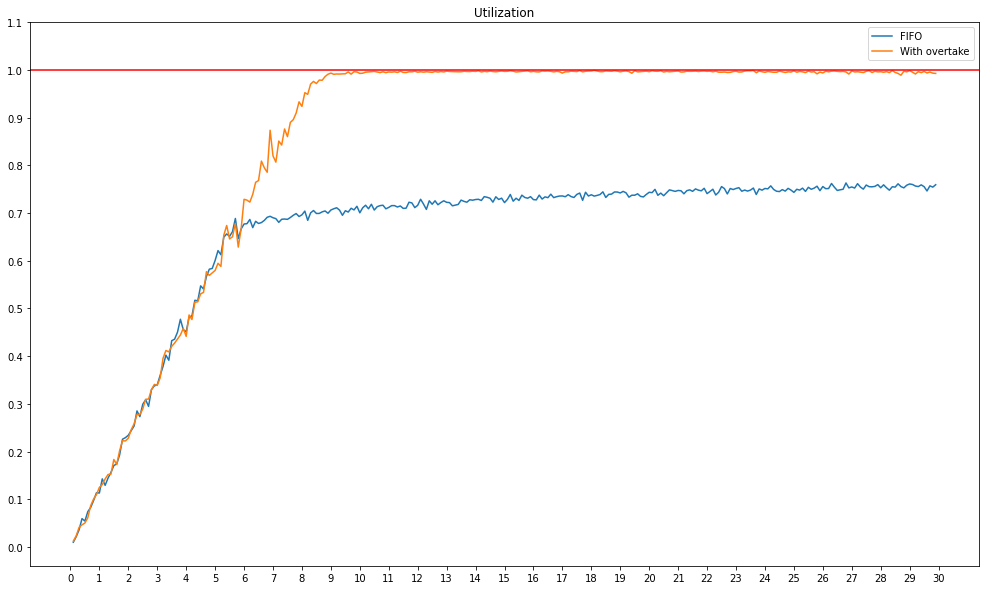

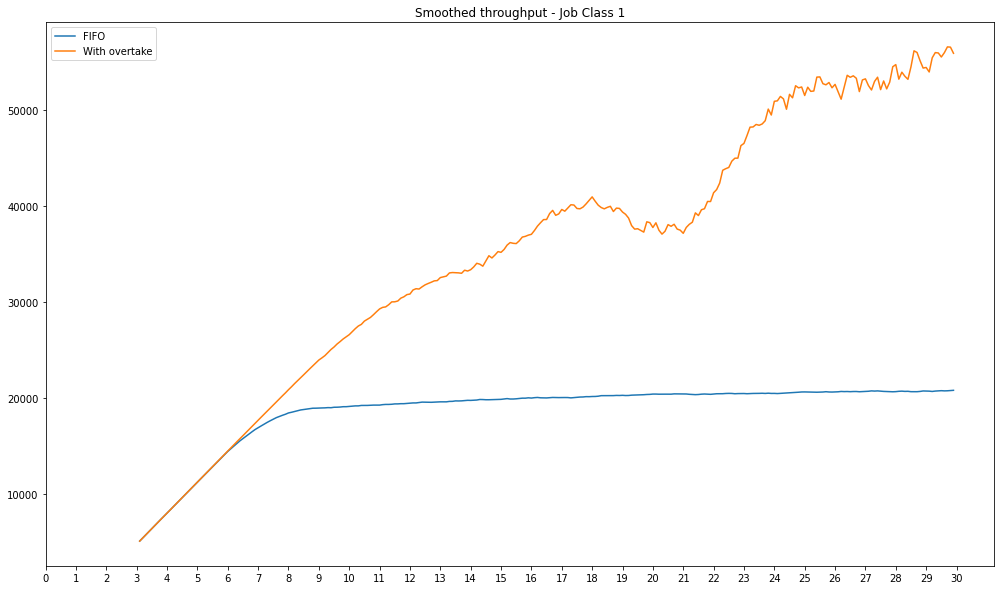

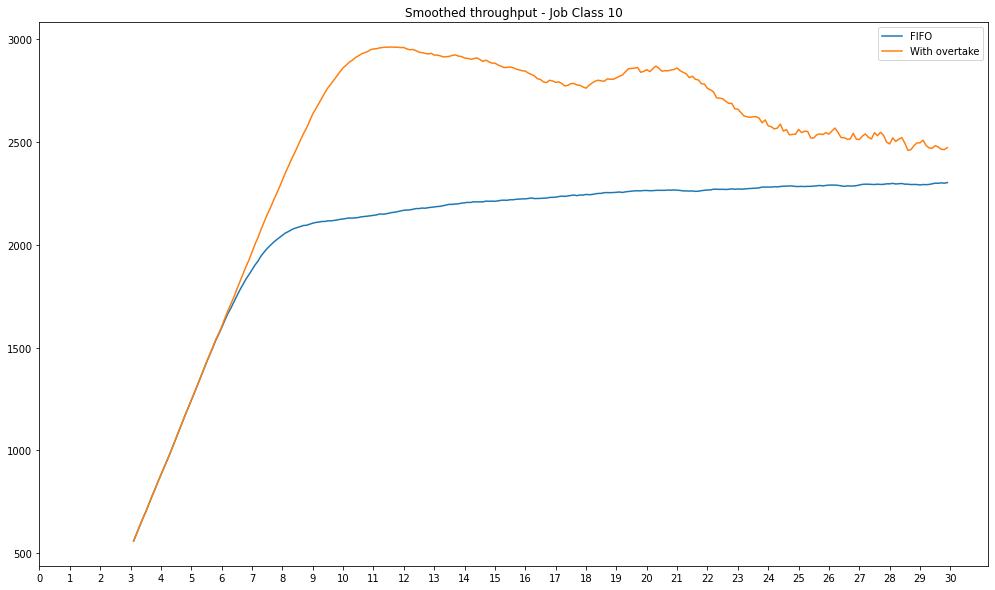

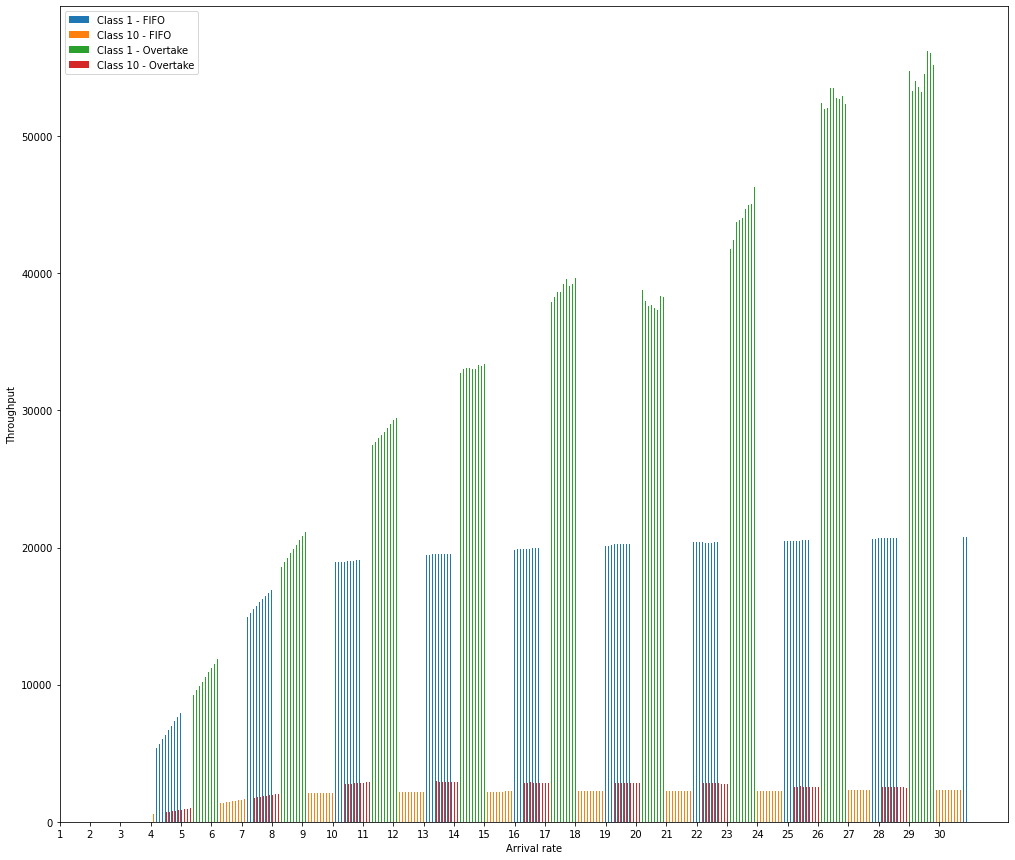

In [183]:
smoothed_thr = []
n = max_lambda
i = n
while i < len(throughputs):
    a = mean([t[0][0] for t in throughputs[i-n:i]])
    b = mean([t[0][1] for t in throughputs[i-n:i]])
    c = mean([t[1][0] for t in throughputs[i-n:i]])
    d = mean([t[1][1] for t in throughputs[i-n:i]])
    smoothed_thr.append([(a,b),(c,d)])
    i += 1

plt.figure(figsize=(17,10))
plt.plot([r for r in np.arange(0.1,max_lambda,0.1)], [u[0] for u in utils], label = 'FIFO')
plt.plot([r for r in np.arange(0.1,max_lambda,0.1)], [u[1] for u in utils], label = 'With overtake')
plt.axhline(y = 1, color = 'r')
plt.yticks(np.arange(0, 1.2, 0.1))
plt.xticks(np.arange(0, max_lambda+1, 1))
plt.legend()
plt.title('Utilization')
plt.show()

plt.figure(figsize=(17,10))
plt.plot([r for r in np.arange(0.1+(n/10),max_lambda,0.1)], [t[0][0] for t in smoothed_thr], label = 'FIFO')
plt.plot([r for r in np.arange(0.1+(n/10),max_lambda,0.1)], [t[1][0] for t in smoothed_thr], label = 'With overtake')
plt.xticks(np.arange(0, max_lambda+1, 1))
plt.legend()
plt.title('Smoothed throughput - Job Class 1')
plt.show()

plt.figure(figsize=(17,10))
plt.plot([r for r in np.arange(0.1+(n/10),max_lambda,0.1)], [t[0][1] for t in smoothed_thr], label = 'FIFO')
plt.plot([r for r in np.arange(0.1+(n/10),max_lambda,0.1)], [t[1][1] for t in smoothed_thr], label = 'With overtake')
plt.xticks(np.arange(0, max_lambda+1, 1))
plt.legend()
plt.title('Smoothed throughput - Job Class 10')
plt.show()

plt.figure(figsize=(17,15))
width = 0.01
plt.bar([n for n in np.arange(0.1+(n/10),max_lambda,0.1)], [t[0][0] for t in smoothed_thr], width = width, label = 'Class 1 - FIFO')
plt.bar([n+width for n in np.arange(0.1+(n/10),max_lambda,0.1)], [t[0][1] for t in smoothed_thr], width = width, label = 'Class 10 - FIFO')
plt.bar([n+(width*2) for n in np.arange(0.1+(n/10),max_lambda,0.1)], [t[1][0] for t in smoothed_thr], width = width, label = 'Class 1 - Overtake')
plt.bar([n+(width*3) for n in np.arange(0.1+(n/10),max_lambda,0.1)], [t[1][1] for t in smoothed_thr], width = width, label = 'Class 10 - Overtake')
plt.legend()
plt.xlabel('Arrival rate')
plt.ylabel('Throughput')
plt.xticks([n+(width) for n in range(max_lambda)],
        [n+1 for n in range(max_lambda)])
plt.show()

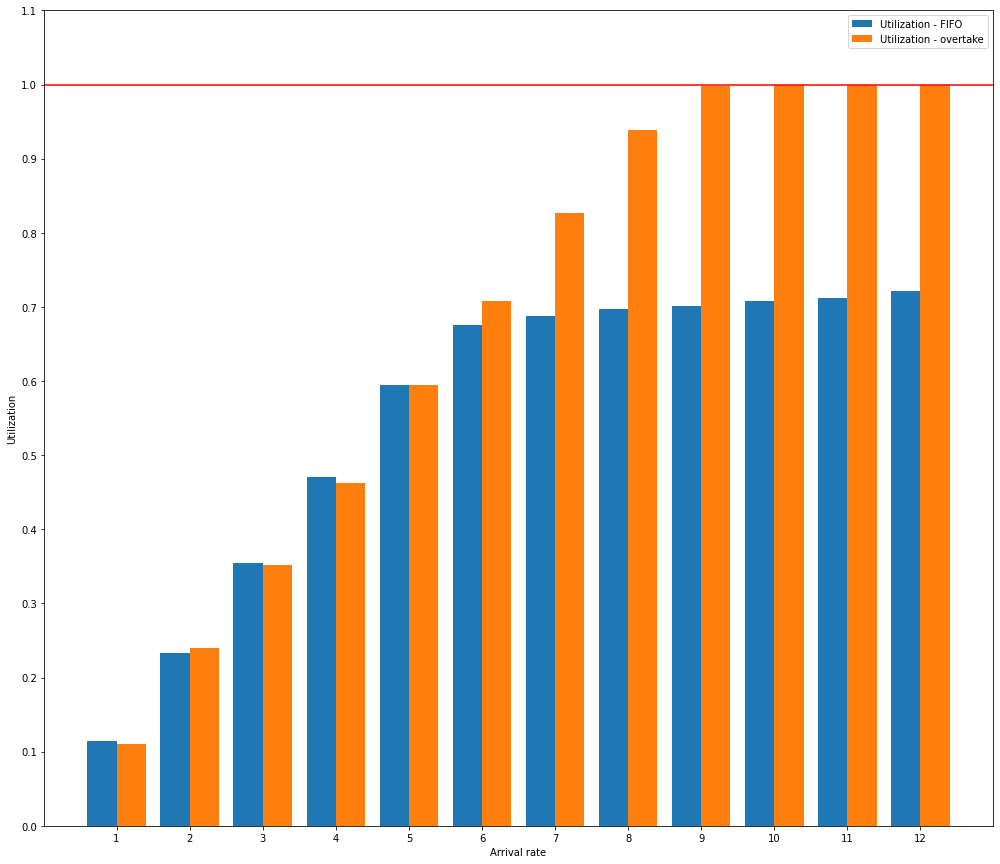

In [93]:
plt.figure(figsize=(17,15))
width = 0.4
plt.bar([n for n in range(max_lambda)], [u[0] for u in utils], width = width, label = 'Utilization - FIFO')
plt.bar([n+width for n in range(max_lambda)], [u[1] for u in utils], width = width, label = 'Utilization - overtake')
plt.legend()
plt.axhline(y = 1, color = 'r')
plt.yticks(np.arange(0, 1.2, 0.1))
plt.xlabel('Arrival rate')
plt.ylabel('Utilization')
plt.xticks([n+(width*0.5) for n in range(max_lambda)],
        [n+1 for n in range(max_lambda)])
plt.show()

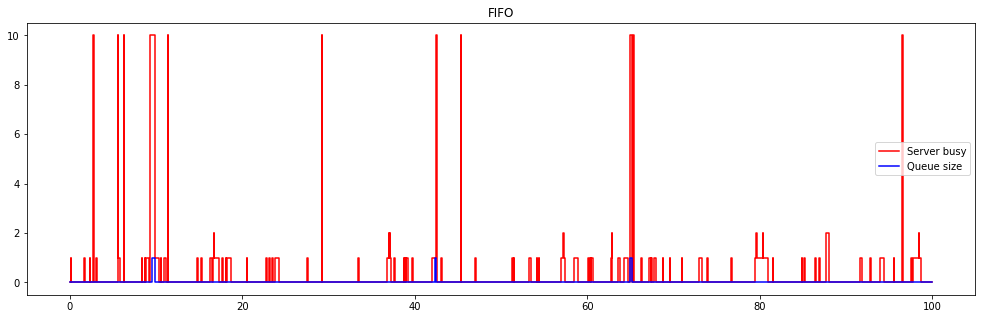

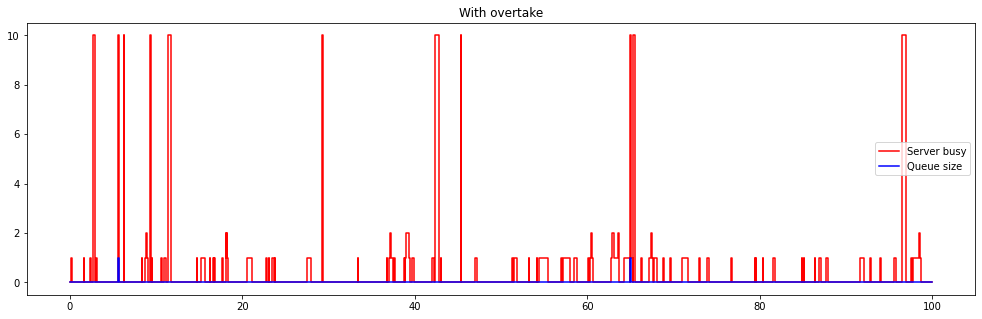

In [25]:
start_t = 0
end_t = 100

server_load = comb_sl[0]
queue_size = comb_qs[0]
tmp_server = []
tmp_queue = []
init_sl = -1
for j in server_load:
    if j[0] < start_t:
        init_sl += 1
        continue
    if j[0] > end_t:
        break
    tmp_server.append(j)
if init_sl >= 0:
    tmp_server = [[start_t,server_load[init_sl][1]]] + tmp_server
tmp_server.append([end_t,tmp_server[-1][1]])

init_qs = -1
for q in queue_size:
    if q[0] < start_t:
        init_qs += 1
        continue
    if q[0] > end_t:
        break
    tmp_queue.append(q)
if init_qs >= 0:
    tmp_queue = [[start_t,queue_size[init_qs][1]]] + tmp_queue
tmp_queue.append([end_t,tmp_queue[-1][1]])

plt.figure(figsize=(17,5))
plt.step([q[0] for q in tmp_server], [q[1] for q in tmp_server], 'r', where='post', label = 'Server busy')
plt.step([q[0] for q in tmp_queue], [q[1] for q in tmp_queue], 'b', where='post', label = 'Queue size')
plt.legend()
plt.title('FIFO')
plt.show()

server_load = comb_sl[1]
queue_size = comb_qs[1]
tmp_server = []
tmp_queue = []
init_sl = -1
for j in server_load:
    if j[0] < start_t:
        init_sl += 1
        continue
    if j[0] > end_t:
        break
    tmp_server.append(j)
if init_sl >= 0:
    tmp_server = [[start_t,server_load[init_sl][1]]] + tmp_server
tmp_server.append([end_t,tmp_server[-1][1]])

init_qs = -1
for q in queue_size:
    if q[0] < start_t:
        init_qs += 1
        continue
    if q[0] > end_t:
        break
    tmp_queue.append(q)
if init_qs >= 0:
    tmp_queue = [[start_t,queue_size[init_qs][1]]] + tmp_queue
tmp_queue.append([end_t,tmp_queue[-1][1]])

plt.figure(figsize=(17,5))
plt.step([q[0] for q in tmp_server], [q[1] for q in tmp_server], 'r', where='post', label = 'Server busy')
plt.step([q[0] for q in tmp_queue], [q[1] for q in tmp_queue], 'b', where='post', label = 'Queue size')
plt.legend()
plt.title('With overtake')
plt.show()

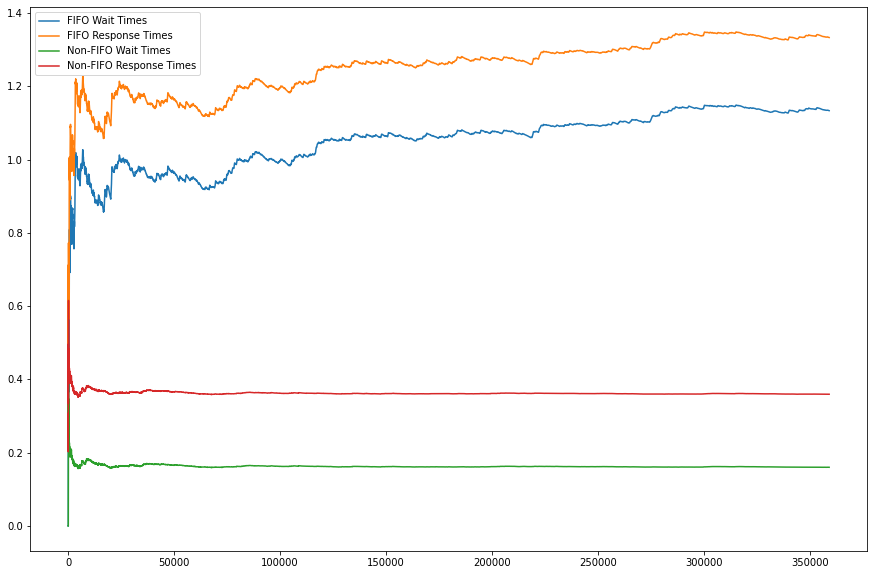

In [35]:
waiting_times = comb_wt[0]
response_times = comb_rt[0]
avg_wait = []
n = 1
tot = 0
for w in [wt[0] for wt in waiting_times]:
    tot += w
    avg_wait.append(tot/n)
    n += 1

avg_resp = []
n = 1
tot = 0
for w in [rt[0] for rt in response_times]:
    tot += w
    avg_resp.append(tot/n)
    n += 1

plt.figure(figsize=(15,10))
plt.plot([i for i in range(len(avg_wait))], avg_wait, label = "FIFO Wait Times")
plt.plot([i for i in range(len(avg_resp))], avg_resp, label = "FIFO Response Times")

waiting_times = comb_wt[1]
response_times = comb_rt[1]
avg_wait = []
n = 1
tot = 0
for w in [wt[0] for wt in waiting_times]:
    tot += w
    avg_wait.append(tot/n)
    n += 1

avg_resp = []
n = 1
tot = 0
for w in [rt[0] for rt in response_times]:
    tot += w
    avg_resp.append(tot/n)
    n += 1

plt.plot([i for i in range(len(avg_wait))], avg_wait, label = "Non-FIFO Wait Times")
plt.plot([i for i in range(len(avg_resp))], avg_resp, label = "Non-FIFO Response Times")
plt.legend()
plt.show()

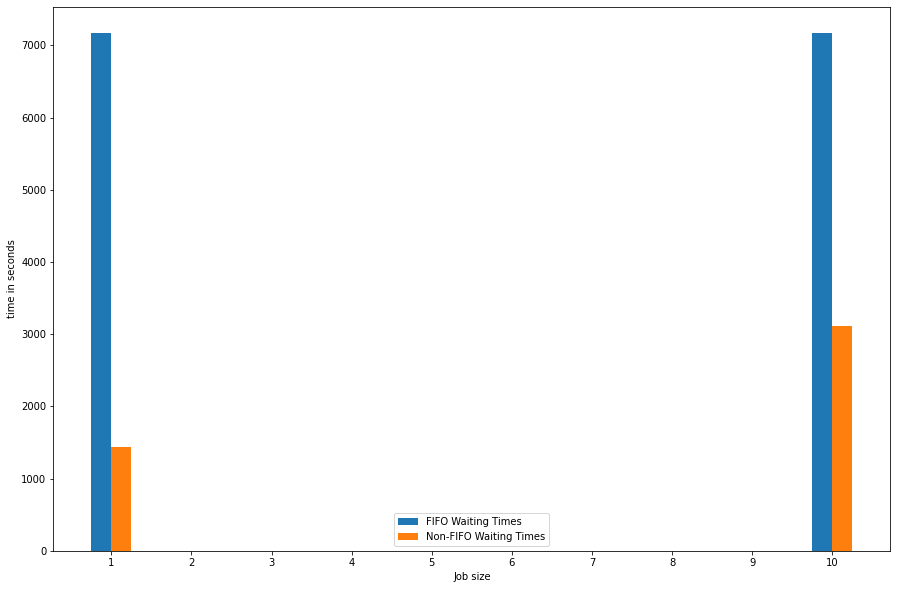

In [68]:
width = 0.25

waiting_times = comb_wt[0]
response_times = comb_rt[0]
boxed_wait = []
for i in range(job_size):
    job_size = i+1
    tmp_wait = []
    for wt in waiting_times:
        if wt[1] == job_size:
            tmp_wait.append(wt[0])
    if len(tmp_wait) == 0:
        boxed_wait.append(0)
        continue
    boxed_wait.append(mean(tmp_wait))

boxed_resp = []
for i in range(job_size):
    job_size = i+1
    tmp_resp = []
    for rt in response_times:
        if rt[1] == job_size:
            tmp_resp.append(rt[0])
    if len(tmp_resp) == 0:
        boxed_resp.append(0)
        continue
    boxed_resp.append(mean(tmp_resp))

plt.figure(figsize=(15,10))
plt.bar([n for n in range(job_size)], boxed_wait, width = width, label = 'FIFO Waiting Times')
#plt.bar([n+1 for n in range(server_n)], boxed_resp, label = 'Avg Response Times')

waiting_times = comb_wt[1]
response_times = comb_rt[1]
boxed_wait = []
for i in range(job_size):
    job_size = i+1
    tmp_wait = []
    for wt in waiting_times:
        if wt[1] == job_size:
            tmp_wait.append(wt[0])
    if len(tmp_wait) == 0:
        boxed_wait.append(0)
        continue
    boxed_wait.append(mean(tmp_wait))

boxed_resp = []
for i in range(job_size):
    job_size = i+1
    tmp_resp = []
    for rt in response_times:
        if rt[1] == job_size:
            tmp_resp.append(rt[0])
    if len(tmp_resp) == 0:
        boxed_resp.append(0)
        continue
    boxed_resp.append(mean(tmp_resp))

plt.bar([n+width for n in range(job_size)], boxed_wait, width = width, label = 'Non-FIFO Waiting Times')
plt.legend()
plt.xlabel('Job size')
plt.ylabel('time in seconds')
plt.xticks([n+(width/2) for n in range(job_size)],
        [n+1 for n in range(job_size)])
plt.show()

In [184]:
waiting_times = comb_wt[0]
response_times = comb_rt[0]
print(mean([wt[0] for wt in waiting_times]))
print(mean([rt[0] for rt in response_times]))
print('----------')

waiting_times = comb_wt[1]
response_times = comb_rt[1]
print(mean([wt[0] for wt in waiting_times]))
print(mean([rt[0] for rt in response_times]))

1412.7181935879667
1412.9999832583112
----------
1142.1619594918998
1142.3966942422762


In [120]:
for i in np.arange(0.1,12,0.1):
    print(i)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.700000000000001
9.8
9.9
10.0
10.1
10.200000000000001
10.3
10.4
10.5
10.6
10.700000000000001
10.8
10.9
11.0
11.1
11.200000000000001
11.3
11.4
11.5
11.6
11.700000000000001
11.8
11.9
